In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report

from tensorflow import keras
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import load_model


import random

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
data = pd.read_csv('/content/drive/My Drive/thesis/data.csv')

In [21]:
sampled_data = data.sample(n=10000, random_state=42)

In [22]:
def create_3d_array(data, window_size):
    samples, features = data.shape
    new_samples = samples - window_size + 1

    # Initialize an empty array for the 3D data
    result = np.zeros((new_samples, window_size, features))

    # Populate the 3D array using a rolling window
    for i in range(new_samples):
        result[i, :, :] = data.iloc[i:i+window_size, :].values

    return result

In [23]:
X=sampled_data

In [24]:
window_size = 120
X_final_reshaped = create_3d_array(X, window_size)

In [25]:
y_final_reshaped = X_final_reshaped[:, :, -1:]
X_final_reshaped = X_final_reshaped[:, :, :-1]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_final_reshaped, y_final_reshaped, test_size=0.2, random_state=42)

In [13]:
! pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=8eb0925282db104474ba7fe159dc529664bf5176bc4d21112ac3d0c003308ce6
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [14]:
from pyswarm import pso
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout, RepeatVector

In [15]:
def build_lstm_model(input_shape, lstm_units_layer1, lstm_units_layer2, dropout_rate):
    model = Sequential([
        LSTM(lstm_units_layer1, activation='tanh', return_sequences=True, input_shape=input_shape),
        LSTM(lstm_units_layer2, activation='tanh', return_sequences=False),
        Dropout(rate=dropout_rate),
        RepeatVector(input_shape[0]),
        LSTM(lstm_units_layer2, activation='tanh', return_sequences=True),
        LSTM(lstm_units_layer1, activation='tanh', return_sequences=True),
        Dropout(rate=dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [16]:
def lstm_pso_objective(params):
    lstm_units_layer1 = int(params[0])
    lstm_units_layer2 = int(params[1])
    dropout_rate = params[2]
    batch_size = int(params[3])

    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), lstm_units_layer1, lstm_units_layer2, dropout_rate)
    model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.1,
              callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], verbose=0)

    y_pred = model.predict(X_test)
    y_test_final = y_test[:,0,:]
    y_pred_final = y_pred[:,0,:]
    mse = np.mean(np.power(y_test_final - y_pred_final, 2), axis=1)
    threshold = np.percentile(mse, 95)
    y_pred = (mse > threshold).astype(int)

    f1 = f1_score(y_test_final.flatten(), y_pred)
    return -f1

In [17]:
lb = [10, 10, 0.1, 32]
ub = [100, 100, 0.5, 128]

best_params, best_f1 = pso(lstm_pso_objective, lb, ub, swarmsize=10, maxiter=20)
print("Best parameters found:", best_params)
print("Best F1 score achieved:", -best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Stopping search: maximum iterations reached --> 20
Best parameters found: [ 61.39910445  28.42386401   0.26316914 101.74504244]
Best F1 score achieved: 0.7967479674796748


In [20]:
pso_params = {'units_1': 61, 'units_2': 28, 'dropout_rate': 0.26, 'batch_size': 102, 'learning_rate': 0.0001}

In [27]:
window_size = X_train.shape[1]
number_of_features = X_train.shape[2]

pso_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(pso_params['units_1'], activation='tanh', return_sequences=True, input_shape=(window_size, number_of_features)),
    tf.keras.layers.LSTM(pso_params['units_2'], activation='tanh', return_sequences=False),
    tf.keras.layers.Dropout(pso_params['dropout_rate']),
    tf.keras.layers.RepeatVector(window_size),
    tf.keras.layers.LSTM(pso_params['units_2']//2, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(pso_params['units_1'], activation='tanh', return_sequences=True),
    tf.keras.layers.Dropout(pso_params['dropout_rate']),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(pso_params['learning_rate'], clipvalue=1.0)
pso_model.compile(optimizer=optimizer, loss='mse')
pso_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_210"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_840 (LSTM)                      │ (None, 120, 61)             │          20,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_841 (LSTM)                      │ (None, 28)                  │          10,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_420 (Dropout)                │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_210 (RepeatVector)     │ (None, 120, 28)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_842 (LSTM)                      │ (None, 120, 14)             │           2,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_843 (LSTM)                      │ (None, 120, 61)             │          18,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_421 (Dropout)                │ (None, 120, 61)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_210 (Dense)                    │ (None, 120, 1)              │              62 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,102 (199.62 KB)

 Trainable params: 51,102 (199.62 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
history = pso_model.fit(X_train, y_train, epochs=50, batch_size=pso_params['batch_size'], validation_split=0.1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], verbose=1)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0556 - val_loss: 0.0537
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0546 - val_loss: 0.0537
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0546 - val_loss: 0.0537
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0549 - val_loss: 0.0536
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0545 - val_loss: 0.0536
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0550 - val_loss: 0.0536
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0544 - val_loss: 0.0536
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0546 - val_loss: 0.0536
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0543 - val_loss: 0.0534
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0545 - val_loss: 0.0534
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0545 - val_loss: 0.0534
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

In [29]:
y_pred = pso_model.predict(X_test)
y_test_final = y_test[:,0,:]
y_pred_final = y_pred[:,0,:]
print(y_pred_final.shape)

print(y_test_final.shape)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
(1977, 1)
(1977, 1)


In [30]:
mse = np.mean(np.power(y_test_final - y_pred_final, 2), axis=1)

# Set a threshold for identifying anomalies
threshold = np.percentile(mse, 95)
threshold

#0.8989490184036354 Random Search

0.9050407660776816

In [31]:
# Classify data points as normal (0) or anomaly (1) based on the threshold
y_pred = (mse > threshold).astype(int)

precision = precision_score(y_test_final, y_pred)
recall = recall_score(y_test_final, y_pred)
f1 = f1_score(y_test_final, y_pred)

# Print all evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 1.0000
Recall: 0.8609
F1-score: 0.9252


In [32]:
# Evaluate model performance using labeled data
accuracy = accuracy_score(y_test_final, y_pred)
conf_matrix = confusion_matrix(y_test_final, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9919
Confusion Matrix:
[[1862    0]
 [  16   99]]


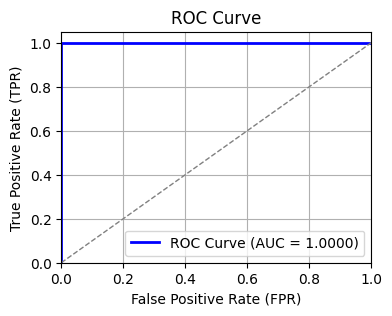

In [33]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_final, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [34]:
pso_model.save('/content/drive/My Drive/thesis/pso_lstm.keras')